<br>

# Explainable AI (XAI)
---
<br>

1. CAM : Class Activation Map <br><br>

    특성추출을 위한 CNN 네트워크 + GAP + Softmax 형태로 구성되야 함 (제약) <br><br>


2. Grad-CAM : Gradient Class Activation Map <br><br>

    모델 구조의 제약이 없음

<br>

<br>

## 데이터셋 준비 <br><br>


Tensorflow Datasets 의 Cars196 데이터셋 : <br>

- 196 종 자동차 종류를 팔별하기 위한 이미지 데이터셋 <br>
    학습셋 : 8144 개 이미지 <br>
    평가셋 : 8041 개 이미지 <br>

- label 로 판별대상의 위치정보인 bounding box 정보를 포함 <br><br>

    참고. <br>
    일정 버전 이상의 ```tensorflow_datasets``` 라이브러리가 설치되어야 car196 데이터셋을 사용할 수 있습니다.

<br>

In [1]:
# 모듈 임포트

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
# GPU 사용 확인

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# tensorflow_datasets 에서 car196 데이터셋 다운로드 (또는 불러오기)
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의.

import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

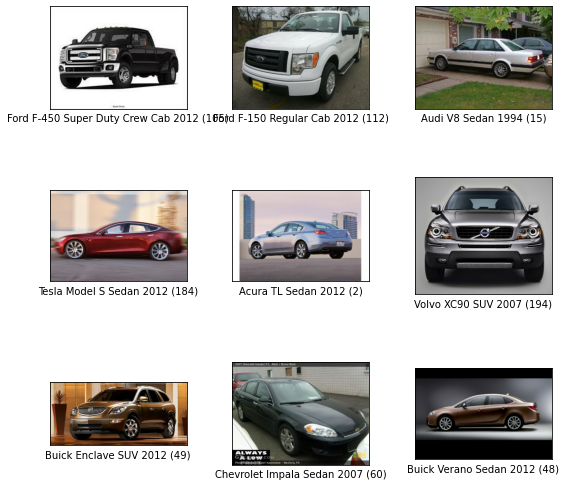

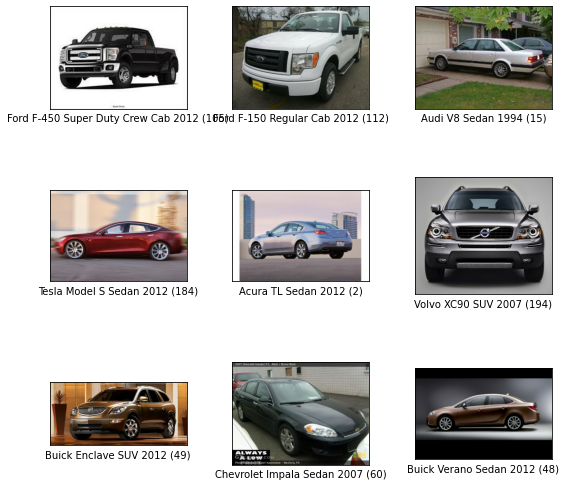

In [4]:
# 학습셋 샘플 확인
# tfds.show_exmaples() 메소드로 샘플 이미지의 클래스와 그 인덱스 확인

tfds.show_examples(ds_train, ds_info)

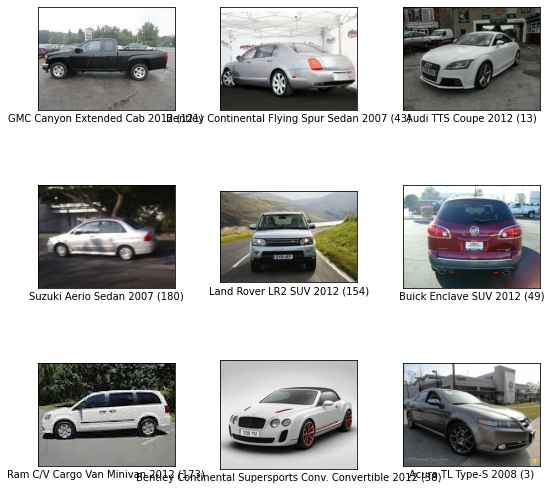

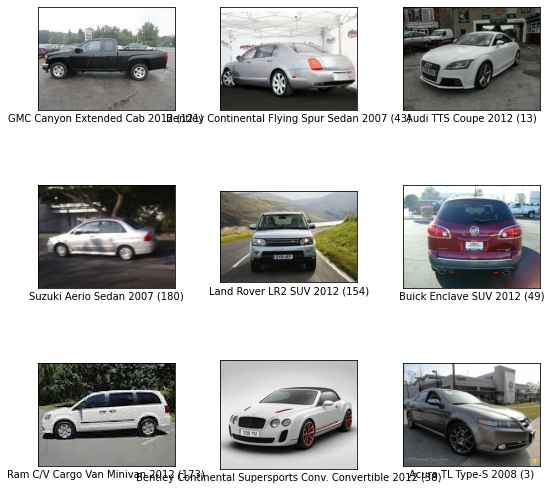

In [5]:
# 평가셋 샘플 확인

tfds.show_examples(ds_test, ds_info)

<br>

## 데이터셋에서 필요한 정보 추출 : 대상의 위치정보 불러오기 <br><br>

Explainable AI 인 CAM 과 Grad-CAM 모델을 수행하기 위해서는 <br>

1. classification task 를 수행하기 위한 이미지 내 대상의 label 과 <br>

2. class activation map task 를 수행하기 위한 이미지 내 대상의 위치정보 두 가지가 필요 <br><br><br>



### Bounding Box <br><br>

```tensorflow_datasets``` 에는 label 외에 bbox 라는 정보도 들어있습니다. (BBoxFeature 타입으로 정의) <br>
bbox (bounding box) 는 이미지 내에서 판별하고자 하는 대상의 위치를 사각형으로 표기한 것입니다. <br><br>

참고. [BBoxFeature](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)<br><br><br>



### Bounding Box 표기 방법들 <br><br>

Bounding Box 를 표기하는 방법은 여러가지가 있습니다. <br>
```tensorflow_datasets``` 에서는 __minmax__ 방식을 사용합니다. <br><br>

- __xywh__ 표기법 : 바운딩 박스의 중심점 (또는 좌상단) 을 x, y 로 표기하고, 사각형 너비와 높이를 w, h 로 표기 <br>
    ex. (x_center, y_center, width, height) <br><br>

- __minmax__ 표기법 : 바운딩 박스를 만드는 좌표의 최소값과 최대값을 통해 사각형 위치를 표기 <br>
    ex. (x_min, x_max, y_min, y_max) <br><br>

- __LRTB__ 표기법, __QUAD__ 표기법 등 그 외에도 다양

<br>

In [6]:
# tfds 데이터셋의 메타정보인 ds_info 를 통해 features 구성 확인

ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

<br><br>

# Class Activation Map (CAM)
---
<br>

" 각 클래스에 대한 활성화 정도를 나타낸 지도(map) " <br><br>

- 기본적으로 분류(classification task) 수행 모델을 대상으로 CAM 시각화가 가능 ! <br>

- 이미지 내에서 클래스가 활성화 된 위치를 확인하고 정답과 비교하는 것이므로, <br>
    이미지 내 위치 정보 데이터가 함께 필요 <br><br>

Feature extraction network (특성을 추출하는 네트워크) 인 CNN 네트워크 뒤에 <br>
Global Average Pooling (GAP) 레이어와 활성화 레이어로 Softmax layer 가 붙는 형태로 구성

<br>

<br>

## CAM 을 위한 모델 구현 <br><br>


CAM 모델은 우리가 해왔던 분류 문제를 위한 모델과 크게 다른 점이 없습니다. <br>
pooling layer 대신에 global-average pooling layer 를 사용하고, <br>
마지막 fully connected layer 대신 GAP을 사용해주기만 하면 됩니다. <br><br>


특성추출을 위한 CNN 네트워크 + GAP + Softmax 형태로 구성 <br><br>

- 특성추출을 위한 CNN 네트워크 : imagenet 데이터로 훈련된 ResNet-50 모델을 활용 <br>

- GAP : global pooling layer <br>
    [keras.applications.ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50) 의 매개변수 pooling 에 'avg' 를 매개변수로 전달 <br>

- Activation : Softmax 함수를 활성화 함수로 사용하는 Fully Connected layer 

<br>

In [7]:
# CAM 을 위한 모델 구성

num_classes = ds_info.features["label"].num_classes

base_model = keras.applications.resnet.ResNet50(
    include_top=False,      # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP (global average pooling) 적용  
)
x = base_model.output

# 위에서 제거한 fully connected layer 자리에 softmax fully connected layer 추가
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)

cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
# 모델 구성 확인

cam_model.summary()

[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]   

<br>

### CAM 모델 학습 <br><br>


#### 학습을 위한 데이터셋 전처리 <br><br>

학습 데이터와 검증데이터에 전처리 수행 <br>

1. Normalizing <br>

2. Resizing <br><br>


학습을 위한 데이터셋의 전처리와 배치 구성을 위한 함수 작성 <br> 

- ```normalize_and_resize_img()``` 함수 작성 <br>

- ```apply_normalize_on_dataset()``` 함수 작성 <br><br>


input 으로 들어가는 데이터셋에 위에서 본 것처럼 bbox 정보가 포함되어 있지만, <br>
CAM 모델의 학습에는 필요하지 않으므로 ```normalize_and_resize_img``` 과정에서 bbox 정보 제외 함 <br><br>

CAM 은 bounding box 같은 직접적인 label 을 사용하지 않고, <br>
weakly supervised learning 을 통해 물체의 영역을 간접적으로 학습시키는 방식 !

<br>

In [9]:
# 이미지를 Normaling 과 Resizing 하는 함수 작성

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [10]:
# 데이터셋에 normalize_and_resize_ima() 함수를 적용하고
# 학습을 위한 배치 처리를 하여 input 데이터셋 생성하는 함수 작성

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
# 데이터셋에 전처리와 배치처리를 적용

ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [12]:
# 구성된 배치의 모양을 확인

for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [13]:
# 모델 컴파일

tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [ ]:
# 모델 학습

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
#  학습된 가중치 저장

import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

<br>

## 학습된 모델 활용하여 CAM 생성 <br><br>

학습 이후 메모리가 부족할 수 있으므로, <br>
학습된 모델을 저장한 뒤 커널을 재시작하여 학습된 모델을 불러오는 것을 추천

<br>

In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3

urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

<br>

### CAM 생성 적용을 위한 데이터 준비 <br><br>

CAM 생성 작업은 학습처럼 데이터셋에서 배치 단위로 이루어지지 않습니다. <br>
개별 이미지 단위로 이루어지기 때문에, 데이터셋에서 이미지 한 장씩 뽑기 위한 ```get_one()``` 함수를 작성하여 사용합니다.

<br>

In [2]:
# 데이터셋에서 이미지 한 장씩 불러오는 함수 작성

def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

173


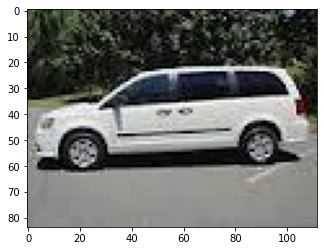

In [3]:
# 이미지 한 장 불러와서 확인

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

<br>

### 학습된 모델을 사용하여 CAM 생성 <br><br>


#### CAM 생성을 위해 필요한 것들 <br><br>

아래의 것들을 고려하여 적용할 model 과 적용 대상 item 에 대하여 <br>
입력 이미지와 동일한 크기의 CAM 을 반환하는 함수를 작성해야 합니다 ! <br><br>

1. Feature Map : 특성 맵 <br>

2. Softmax layer output (?) : 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치 <br>

3. classification output (?) : 원하는 클래스의 출력값 <br><br>


#### CAM 결과를 반환하는 함수 <br><br>

위에서 고려한 CAM 결과를 반환하는 함수 ```generate_cam()``` 을 작성합니다. <br>

1. ```conv_outputs``` 같은 특정 레이어의 결과값을 output 으로 받기 위해 새로운 모델을 정의해야 합니다. <br>
    ( feedforward 를 거친 후 CAM 을 계산하도록 구현 ) <br>

2. 마지막에는 입력 이미지의 크기에 맞춰 CAM 결과를 ```resize``` !

<br>

In [4]:
# 이전에 학습한 모델 불러오기

import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [5]:
# CAM 결과를 반환하기 위한 함수 작성

def generate_cam(model, item):
    
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.

    return cam_image

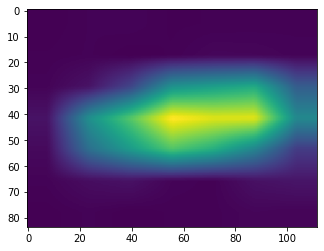

In [6]:
# 특정 item 하나에 대한 CAM 결과 확인

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

<br>

### CAM 결과 원본이미지에 시각화 <br><br>

CAM 결과 이미지를 원본 이미지와 합쳐봅시다. <br>
CAM이 차종을 식별하는데 중요한 이미지 부분을 잘 포착하는지 확인 <br><br>

차량 전면 엠블럼이 있는 부분이 강조되는 경향이 있습니다. <br>
이는 사람이 차종을 식별할 때 유의해서 보는 부분과 일맥상통 합니다 ! <br><br>


참고. <br>
[OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

<br>

In [7]:
# CAM + 원본 이미지 시각화 함수 작성

def visualize_cam_on_image(src1, src2, alpha=0.75):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

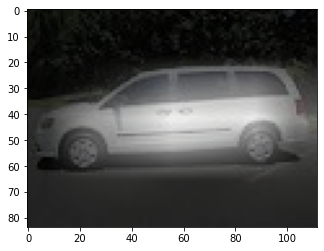

In [8]:
# CAM 결과와 원본이미지 시각화

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

<br><br>

# Gradient Class Activation Map (Grad-CAM)
---
<br>

### CAM <br><br>

" 각 클래스에 대한 활성화 정도를 나타낸 지도(map) " <br><br>

- 기본적으로 분류(classification task) 수행 모델을 대상으로 CAM 시각화가 가능 ! <br>

- 이미지 내에서 클래스가 활성화 된 위치를 확인하고 정답과 비교하는 것이므로, <br>
    이미지 내 위치 정보 데이터가 함께 필요 <br><br>

Feature extraction network (특성을 추출하는 네트워크) 인 CNN 네트워크 뒤에 <br>
Global Average Pooling (GAP) 레이어와 활성화 레이어로 Softmax layer 가 붙는 형태로 구성 <br><br>



### Grad-CAM <br><br>


이번에는 Grad-CAM 을 이용하여 CAM (Class Activation Map) 을 계산 <br><br>

Grad-CAM 은 적용 모델을 유연하게 선택할 수 있습니다. <br>
따라서 CAM 을 위해 만들었던 위 ```cam_model``` 을 그대로 활용 가능합니다. <br><br>

#### ```grad_cam``` <br>

```grad_cam``` 은 관찰하고자 하는 layer 의 출력과 정답 클래스에 대한 prediction (예측값) 사이의 gradient 를 구하고, <br>
여기에 GAP (Global Average Pooling) 을 적용해 관찰하고자 하는 레이어의 '채널별 가중치' 를 구합니다. <br><br>

CAM 결과 이미지를 구하기 위해 <br>
위에서 구한 layer 의 '채널별 가중치' (weights) 와 layer 에서 나오는 '채널별 특성맵' (feature map) 을 가중합 하여 ```cam_image``` 를 구합니다.

<br>

<br>

### 학습된 모델을 사용하여 Grad-CAM 생성 <br><br>


Grad-CAM 은 CAM 과 달리, 어떤 layer 에서든 CAM 결과 이미지를 뽑아낼 수 있습니다 ! <br>
gradient 계산을 원하는 어떤 관찰 대상 layer 에서든 activation layer 를 뽑아 쓸 수 있도록, <br>
```activation_layer``` 의 이름을 받아 이를 활용해야 합니다. <br><br>

#### ```generate_grad_cam()``` 함수 작성 <br><br>

관찰하고자 하는 layer 의 ```output``` 과 특정 클래스의 ```prediction``` 사이에서 ```grad_val``` 를 얻고, <br>
이를 ```weights``` 로 활용하여 CAM 결과 이미지를 구합니다 ! <br><br>


#### ```cam_model``` 리뷰 <br>

특성추출을 위한 CNN 네트워크 + GAP + Softmax 형태로 구성 <br><br>

- 특성추출을 위한 CNN 네트워크 : imagenet 데이터로 훈련된 ResNet-50 모델을 활용 <br>

- GAP : global pooling layer <br>
    [keras.applications.ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50) 의 매개변수 pooling 에 'avg' 를 매개변수로 전달 <br>

- Activation : Softmax 함수를 활성화 함수로 사용하는 Fully Connected layer 

<br>

In [9]:
# 관찰하고자 하는 레이어 별로 grad_val 을 구하고, 
# 이를 활용해 CAM 결과 이미지를 구하는 함수 작성

def generate_grad_cam(model, activation_layer, item):

    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.


    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

<br>

### Grad-CAM 결과 이미지 확인 <br><br>

```generate_grad_cam``` 함수로 여러 레이어의 CAM 이미지를 뽑아서 확인할 수 있습니다. <br>
레이어의 이름은 ```cam_model.summary()``` 에서 찾을 수 있습니다.

<br>

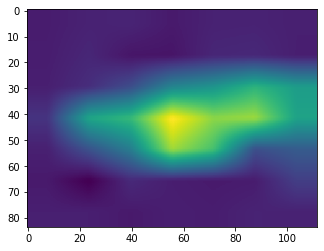

In [10]:
# conv5_block3_out 레이어의 Grad-CAM 결과 이미지 확인

grad_cam_image01 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image01)

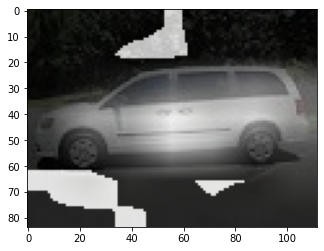

In [11]:
# conv5_block3_out 레이어의 Grad-CAM 결과와 원본이미지 시각화

origin_image01 = item['image'].astype(np.uint8)
grad_cam_image01_3channel = np.stack([grad_cam_image01*255]*3, axis=-1).astype(np.uint8)

blended_image01 = visualize_cam_on_image(grad_cam_image01_3channel, origin_image01)
plt.imshow(blended_image01)

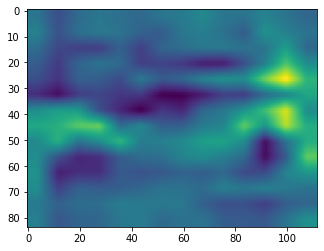

In [12]:
# conv4_block3_out 레이어의 Grad-CAM 결과 이미지 확인

grad_cam_image02 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image02)

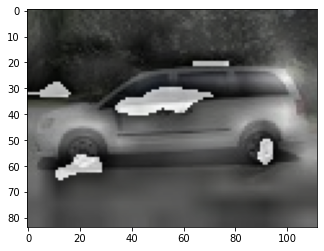

In [13]:
# conv4_block3_out 레이어의 Grad-CAM 결과와 원본이미지 시각화

origin_image02 = item['image'].astype(np.uint8)
grad_cam_image02_3channel = np.stack([grad_cam_image02*255]*3, axis=-1).astype(np.uint8)

blended_image02 = visualize_cam_on_image(grad_cam_image02_3channel, origin_image02)
plt.imshow(blended_image02)

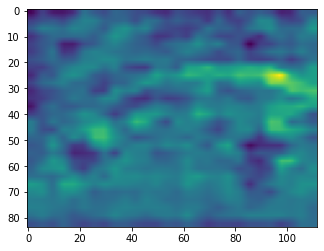

In [14]:
# conv3_block3_out 레이어의 Grad-CAM 결과 이미지 확인

grad_cam_image03 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image03)

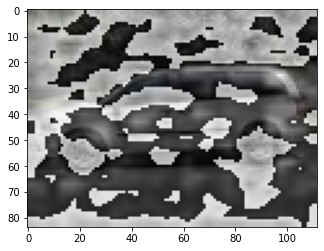

In [15]:
# conv3_block3_out 레이어의 Grad-CAM 결과와 원본이미지 시각화

origin_image03 = item['image'].astype(np.uint8)
grad_cam_image03_3channel = np.stack([grad_cam_image03*255]*3, axis=-1).astype(np.uint8)

blended_image03 = visualize_cam_on_image(grad_cam_image03_3channel, origin_image03)
plt.imshow(blended_image03)

<br>

## Detection with CAM (Grad-CAM) <br><br>

CAM 또는 Grad-CAM 에서 물체 위치를 찾는 detection task 를 수행

<br>

<br>

### CAM 결과 이미지로부터 bounding box 생성하기 <br><br>

```generate_cam``` 을 활용해 얻은 CAM 결과 이미지의 값들 중에서 <br>
일정 역치값 이상의 영역에 대해서 bbox 를 생성합니다. <br><br><br>



#### ```get_bbox()``` 함수 작성 <br><br>

```score_thresh``` 를 받아 역치값 이하의 바운딩 박스를 없앱니다. <br>
그 후, OpenCV 의 ```findCounters()``` 메소드와 ```minAreaRect()``` 메소드로 사각형을 찾습니다. <br>
이 때, 얻어지는 bounding box 는 회전된 바운딩 박스입니다. (?) <br>
```boxPoints()``` 메소드로 이 rect 값을 꼭지접으로 바꾸어 줍니다. <br>
마지막에는 ```int``` 자료형으로 변환해 줍니다.

<br>

In [17]:
# CAM 결과값으로부터 bbox 생성하는 함수 작성

def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [18]:
# CAM 결과값으로부터 얻은 bbox 좌표

image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[  8,  66],
       [  8,  18],
       [110,  19],
       [110,  66]])

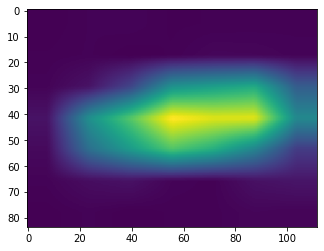

In [16]:
# 샘플 이미지에 대해 generate_cam() 함수로 CAM 결과값 생성

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

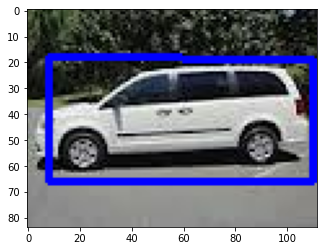

In [19]:
# CAM 결과값으로부터 얻은 bbox 시각화

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

<br>

### Grad-CAM 결과 이미지로부터 bounding box 생성하기

<br>

In [21]:
# conv5_block3_out 레이어의 Grad-CAM 결과값으로부터 얻은 bbox 좌표

image01 = copy.deepcopy(item['image'])
rect01 = get_bbox(grad_cam_image01)
rect01

array([[111,  73],
       [  0,  73],
       [  0,  18],
       [111,  18]])

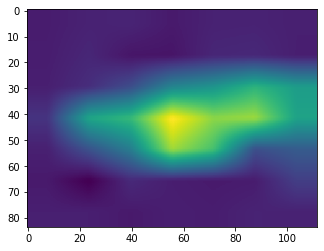

In [34]:
# 샘플 이미지에 대해 generate_grad_cam() 함수로 얻은 conv5_block3_out 레이어의 Grad-CAM 결과 이미지 확인

grad_cam_image01 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image01)

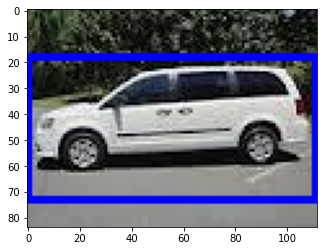

In [22]:
# conv5_block3_out 레이어의 Grad-CAM 결과값으로부터 얻은 bbox 시각화

image01 = cv2.drawContours(image01,[rect01],0,(0,0,255),2)
plt.imshow(image01)

In [37]:
# conv4_block3_out 레이어의 Grad-CAM 결과값으로부터 얻은 bbox 좌표

image02 = copy.deepcopy(item['image'])
rect02 = get_bbox(grad_cam_image02)
rect02

array([[110,  82],
       [  0,  82],
       [  0,   0],
       [110,   0]])

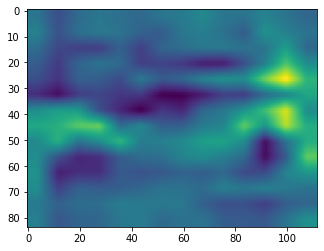

In [38]:
# 샘플 이미지에 대해 generate_grad_cam() 함수로 얻은 conv4_block3_out 레이어의 Grad-CAM 결과 이미지 확인

grad_cam_image02 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image02)

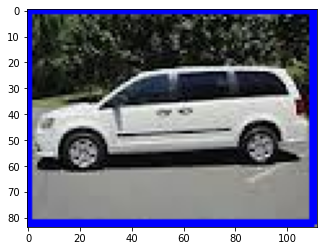

In [39]:
# conv4_block3_out 레이어의 Grad-CAM 결과값으로부터 얻은 bbox 시각화

image02 = cv2.drawContours(image02,[rect02],0,(0,0,255),2)
plt.imshow(image02)

In [40]:
# conv3_block3_out 레이어의 Grad-CAM 결과값으로부터 얻은 bbox 좌표

image03 = copy.deepcopy(item['image'])
rect03 = get_bbox(grad_cam_image03)
rect03

array([[63, 81],
       [58, 79],
       [60, 73],
       [66, 76]])

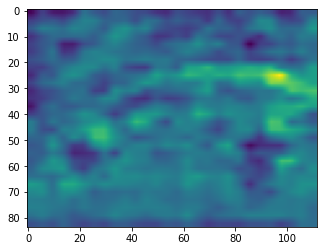

In [41]:
# 샘플 이미지에 대해 generate_grad_cam() 함수로 얻은 conv3_block3_out 레이어의 Grad-CAM 결과 이미지 확인

grad_cam_image03 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image03)

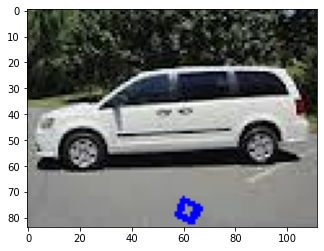

In [42]:
# conv3_block3_out 레이어의 Grad-CAM 결과값으로부터 얻은 bbox 시각화

image03 = cv2.drawContours(image03,[rect03],0,(0,0,255),2)
plt.imshow(image03)

<br>

## Detection with CAM (Grad-CAM) 평가 <br><br>

CAM 과 Grad-CAM 두 방법을 통해 각 레이어들이 집중하고 있는 대상의 바운딩 박스를 detection 할 수 있었습니다. <br>
이 detection 결과를 평가하는 방법으로 IoU (Intersection Over Union) 계산이 있습니다. <br><br><br>


### IoU (Intersection Over Union) <br><br>

$IoU = \frac{\text{Area of Overlap}}{\text{Area of Union}}$ <br><br>

두 개 영역의 합집합인 "union" 영역으로 교집합 영역인 "intersection" 영역의 넓이를 나누어준 값 <br>
찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지 상대적인 비율을 구할 수 있음 <br><br>

-> 정답 데이터의 바운딩 박스와 CAM (또는 Grad-CAM) 결과의 바운딩 박스를 비교 평가하는 방법으로 사용 !

<br>

In [23]:
# rect 의 결과를 bbox 의 minmax 표기법으로 변환해주는 함수 작성
# rect 의 좌표는 (x, y) 형태로, bbox 는 (y_min, x_min, y_max, x_max)의 normalized 형태

def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [24]:
# minmax 로 표기된 bbox 간의 IoU 계산하는 함수 작성

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [21]:
# 샘플 데이터의 ground truth bbox 확인

item['bbox']

array([0.24812031, 0.03      , 0.9398496 , 0.985     ], dtype=float32)

<br>

### Detection with CAM 평가 결과

<br>

In [27]:
# CAM 으로 구한 샘플 데이터의 rect 를 minmax bbox 형태로 치환

pred_bbox_cam = rect_to_minmax(rect, item['image'])
pred_bbox_cam

[0.21428571428571427,
 0.07142857142857142,
 0.7857142857142857,
 0.9821428571428571]

In [29]:
# 샘플 데이터의 CAM 결과 bbox 와 원본 label 의 ground truth bbox 사이 IoU 결과 확인

get_iou(pred_bbox_cam, item['bbox'])

0.8732876154255274

<br>

### Detection with Grad-CAM 평가 결과

<br>

In [28]:
# conv5_block3_out 레이어의 Grad-CAM 으로 구한 샘플 데이터의 rect 를 minmax bbox 형태로 치환

pred_bbox_grad_cam01 = rect_to_minmax(rect01, item['image'])
pred_bbox_grad_cam01

[0.21428571428571427, 0.0, 0.8690476190476191, 0.9910714285714286]

In [30]:
# 샘플 데이터의 conv5_block3_out 레이어의 Grad-CAM 결과 bbox 와 원본 label 의 ground truth bbox 사이 IoU 결과 확인

get_iou(pred_bbox_grad_cam01, item['bbox'])

0.7975609258905841

In [43]:
# conv4_block3_out 레이어의 Grad-CAM 으로 구한 샘플 데이터의 rect 를 minmax bbox 형태로 치환

pred_bbox_grad_cam02 = rect_to_minmax(rect02, item['image'])
pred_bbox_grad_cam02

[0.0, 0.0, 0.9761904761904762, 0.9821428571428571]

In [44]:
# 샘플 데이터의 conv4_block3_out 레이어의 Grad-CAM 결과 bbox 와 원본 label 의 ground truth bbox 사이 IoU 결과 확인

get_iou(pred_bbox_grad_cam02, item['bbox'])

0.5334796646218047

In [45]:
# conv3_block3_out 레이어의 Grad-CAM 으로 구한 샘플 데이터의 rect 를 minmax bbox 형태로 치환

pred_bbox_grad_cam03 = rect_to_minmax(rect03, item['image'])
pred_bbox_grad_cam03

[0.8690476190476191,
 0.5178571428571429,
 0.9642857142857143,
 0.5892857142857143]

In [46]:
# 샘플 데이터의 conv3_block3_out 레이어의 Grad-CAM 결과 bbox 와 원본 label 의 ground truth bbox 사이 IoU 결과 확인

get_iou(pred_bbox_grad_cam03, item['bbox'])

0.0

<br>

## CAM 과 Grad-CAM 을 통한 detection bbox IoU 결과 분석 <br><br>


### IoU 결과 summary <br><br>


1. CAM 을 통한 detection bbox IoU <br>

    0.8732 ... <br><br>


2. conv5_block3_out 레이어의 Grad-CAM 을 통한 detection bbox IoU <br>

    0.7975 ... <br><br>


3. conv4_block3_out 레이어의 Grad-CAM 을 통한 detection bbox IoU <br>

    0.5334 ... <br><br>

4. conv3_block3_out 레이어의 Grad-CAM 을 통한 detection bbox IoU <br>

    0.0000 <br><br><br>



### IoU 결과 분석 <br><br>


#### CAM 결과 <br>

CAM 은 feature map 을 전부 거친 뒤에 <br>
맨 마지막 출력에 출력된 feature map 에 대해서 Class Activation Map 을 생성하므로 <br>
앞 단의 CNN 네트워크 전부를 통해 활성화된 CAM 결과값을 얻게 됩니다. <br><br>

우리가 사용하는 모델이 classification task 를 수행하는데 있어서 <br>
전체적으로 어느 곳을 제일 중점적으로 보았는지를 반영하고 있으며 <br>
그렇기 때문에 detection task 에서 비교적 높은 IoU 값을 보인 것으로 생각됩니다. <br><br>


#### Grad-CAM 결과 <br>

Grad-CAM 은 특정 convolution layer 를 거친 직후에 <br>
출력되는 feature map 에 대해서 Class Activation Map 을 생성하므로 <br>
직전 convolution layer 까지를 통해 활성화된 CAM 결과값을 얻게 됩니다. <br><br>

우리가 사용하는 모델이 classification task 를 수행하는데 있어서 <br>
모델 내부의 특정 convolution layer 의 관점에서 어느 곳을 제일 중점적으로 보았는지를 반영하고 있으며 <br>
그렇기 때문에 detection task 에서는 각 layer 마다 서로 다른 IoU 값을 보이고 있으며, <br>
이미지 전체에서 작고 디테일한 영역을 바라보는 앞쪽 convolution layer 에서는 굉장히 작은 IoU 값을 보이고, <br>
이미지 전체에서 크고 종합적인 영역을 바라보는 뒷쪽 convolution layer 에서는 나름 큰 IoU 값을 보입니다. <br><br>

CNN 네트워크 전체를 거친 feature map 에 대해 계산한 CAM 에 비해서는 <br>
특정 layer 를 거친 feature map 에 대해 계산한 Grad-CAM 이 더 작은 IoU 를 보이는 것 같습니다.

<br>